In [1]:
import warnings
warnings.filterwarnings("ignore")

import sys
import itertools
from keras.utils import plot_model
from keras.layers import Input, Dense, Reshape, Flatten
from keras import layers, initializers
from keras.models import Model, load_model
import keras.backend as K
import numpy as np
from seqtools import SequenceTools as ST
from gfp_gp import SequenceGP
from util import AA, AA_IDX
from util import build_vae
from sklearn.model_selection import train_test_split, ShuffleSplit
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import pandas as pd
from gan import WGAN
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF, ConstantKernel as C
import scipy.stats
from scipy.stats import norm
from scipy.optimize import minimize
from keras.utils.generic_utils import get_custom_objects
from util import one_hot_encode_aa, partition_data, get_balaji_predictions, get_samples
from util import convert_idx_array_to_aas, build_pred_vae_model, get_experimental_X_y, count_substring_mismatch
from util import get_gfp_X_y_aa, load_gfp_data, one_hot_encode_aa, one_hot_encode, get_all_amino_acids, get_wild_type_amino_acid_sequence
from losses import neg_log_likelihood
import json
class color:
   PURPLE = '\033[95m'
   CYAN = '\033[96m'
   DARKCYAN = '\033[36m'
   BLUE = '\033[94m'
   GREEN = '\033[92m'
   YELLOW = '\033[93m'
   RED = '\033[91m'
   BOLD = '\033[1m'
   UNDERLINE = '\033[4m'
   END = '\033[0m'

Using TensorFlow backend.


In [2]:
def build_model(M):
    x = Input(shape=(M, 20,))
    y = Flatten()(x)
    y = Dense(50, activation='elu')(y)
    y = Dense(2)(y)
    model = Model(inputs=x, outputs=y)
    return model

def evaluate_ground_truth(X_aa, ground_truth, save_file=None):
    y_gt = ground_truth.predict(X_aa, print_every=100000)[:, 0]
    if save_file is not None:
        np.save(save_file, y_gt)
        
def train_and_save_oracles(X_train, y_train, n=10, suffix='', batch_size=100):
    for i in range(n):
        model = build_model(X_train.shape[1])
        model.compile(optimizer='adam',
                      loss=neg_log_likelihood,
                      )
        early_stop = EarlyStopping(monitor='val_loss', 
                                   min_delta=0, 
                                   patience=5, 
                                   verbose=1)

        model.fit(X_train, y_train, 
                  epochs=100, 
                  batch_size=batch_size, 
                  validation_split=0.1, 
                  callbacks=[early_stop],
                  verbose=2)
        model.save("models/oracle_%i%s.h5" % (i, suffix))

In [3]:
def weighted_ml_opt(X_train, oracles, ground_truth, vae_0, weights_type='dbas',
        LD=20, iters=20, samples=500, homoscedastic=False, homo_y_var=0.1,
        quantile=0.95, verbose=False, alpha=1, train_gt_evals=None,
        cutoff=1e-6, it_epochs=10, enc1_units=50):
    
    assert weights_type in ['cbas', 'dbas','rwr', 'cem-pi', 'fbvae']
    L = X_train.shape[1]
    vae = build_vae(latent_dim=LD,
                    n_tokens=20, seq_length=L,
                    enc1_units=enc1_units)

    traj = np.zeros((iters, 7))
    oracle_samples = np.zeros((iters, samples))
    gt_samples = np.zeros((iters, samples))
    oracle_max_seq = None
    oracle_max = -np.inf
    gt_of_oracle_max = -np.inf
    y_star = - np.inf
    for t in range(iters):
        ### Take Samples ###
        zt = np.random.randn(samples, LD)
        if t > 0:
            Xt_p = vae.decoder_.predict(zt)
            Xt = get_samples(Xt_p)
        else:
            Xt = X_train
        
        ### Evaluate ground truth and oracle ###
        yt, yt_var = get_balaji_predictions(oracles, Xt)
        if homoscedastic:
            yt_var = np.ones_like(yt) * homo_y_var
        Xt_aa = np.argmax(Xt, axis=-1)
        if t == 0 and train_gt_evals is not None:
            yt_gt = train_gt_evals
        else:
            yt_gt = ground_truth.predict(Xt_aa, print_every=1000000)[:, 0]
        
        ### Calculate weights for different schemes ###
        if t > 0:
            if weights_type == 'cbas': 
                log_pxt = np.sum(np.log(Xt_p) * Xt, axis=(1, 2))
                X0_p = vae_0.decoder_.predict(zt)
                log_px0 = np.sum(np.log(X0_p)*Xt, axis=(1, 2))
                w1 = np.exp(log_px0-log_pxt)
                y_star_1 = np.percentile(yt, quantile*100)
                if y_star_1 > y_star:
                    y_star = y_star_1
                w2= scipy.stats.norm.sf(y_star, loc=yt, scale=np.sqrt(yt_var))
                weights = w1*w2 
            elif weights_type == 'cem-pi':
                pi = scipy.stats.norm.sf(max_train_gt, loc=yt, scale=np.sqrt(yt_var))
                pi_thresh = np.percentile(pi, quantile*100)
                weights = (pi > pi_thresh).astype(int)
            elif weights_type == 'dbas':
                y_star_1 = np.percentile(yt, quantile*100)
                if y_star_1 > y_star:
                    y_star = y_star_1
                weights = scipy.stats.norm.sf(y_star, loc=yt, scale=np.sqrt(yt_var))
            elif weights_type == 'rwr':
                weights = np.exp(alpha*yt)
                weights /= np.sum(weights)
#             elif weights_type == ''
        else:
            weights = np.ones(yt.shape[0])
            max_train_gt = np.max(yt_gt)
            
        yt_max_idx = np.argmax(yt)
        yt_max = yt[yt_max_idx]
        if yt_max > oracle_max:
            oracle_max = yt_max
            try:
                oracle_max_seq = convert_idx_array_to_aas(Xt_aa[yt_max_idx-1:yt_max_idx])[0]
            except IndexError:
                print(Xt_aa[yt_max_idx-1:yt_max_idx])
            gt_of_oracle_max = yt_gt[yt_max_idx]
        
        ### Record and print results ##
        if t == 0:
            rand_idx = np.random.randint(0, len(yt), samples)
            oracle_samples[t, :] = yt[rand_idx]
            gt_samples[t, :] = yt_gt[rand_idx]
        if t > 0:
            oracle_samples[t, :] = yt
            gt_samples[t, :] = yt_gt
        
        traj[t, 0] = np.max(yt_gt)
        traj[t, 1] = np.mean(yt_gt)
        traj[t, 2] = np.std(yt_gt)
        traj[t, 3] = np.max(yt)
        traj[t, 4] = np.mean(yt)
        traj[t, 5] = np.std(yt)
        traj[t, 6] = np.mean(yt_var)
        
        if verbose:
            print(weights_type.upper(), t, traj[t, 0], color.BOLD + str(traj[t, 1]) + color.END, 
                  traj[t, 2], traj[t, 3], color.BOLD + str(traj[t, 4]) + color.END, traj[t, 5], traj[t, 6])
        
        ### Train model ###
        if t == 0:
            vae.encoder_.set_weights(vae_0.encoder_.get_weights())
            vae.decoder_.set_weights(vae_0.decoder_.get_weights())
            vae.vae_.set_weights(vae_0.vae_.get_weights())
        else:
            cutoff_idx = np.where(weights < cutoff)
            Xt = np.delete(Xt, cutoff_idx, axis=0)
            yt = np.delete(yt, cutoff_idx, axis=0)
            weights = np.delete(weights, cutoff_idx, axis=0)
            vae.fit([Xt], [Xt, np.zeros(Xt.shape[0])],
                  epochs=it_epochs,
                  batch_size=10,
                  shuffle=False,
                  sample_weight=[weights, weights],
                  verbose=0)
            
    max_dict = {'oracle_max' : oracle_max, 
                'oracle_max_seq': oracle_max_seq, 
                'gt_of_oracle_max': gt_of_oracle_max}
    return traj, oracle_samples, gt_samples, max_dict


In [4]:
def fb_opt(X_train, oracles, ground_truth, vae_0, weights_type='fbvae',
        LD=20, iters=20, samples=500, 
        quantile=0.8, verbose=False, train_gt_evals=None,
        it_epochs=10, enc1_units=50):
    
    assert weights_type in ['fbvae']
    L = X_train.shape[1]
    vae = build_vae(latent_dim=LD,
                    n_tokens=20, seq_length=L,
                    enc1_units=enc1_units)

    traj = np.zeros((iters, 7))
    oracle_samples = np.zeros((iters, samples))
    gt_samples = np.zeros((iters, samples))
    oracle_max_seq = None
    oracle_max = -np.inf
    gt_of_oracle_max = -np.inf
    y_star = - np.inf
    for t in range(iters):
        ### Take Samples and evaluate ground truth and oracle ##
        zt = np.random.randn(samples, LD)
        if t > 0:
            Xt_sample_p = vae.decoder_.predict(zt)
            Xt_sample = get_samples(Xt_sample_p)
            yt_sample, _ = get_balaji_predictions(oracles, Xt_sample)
            Xt_aa_sample = np.argmax(Xt_sample, axis=-1)
            yt_gt_sample = ground_truth.predict(Xt_aa_sample, print_every=1000000)[:, 0]
        else:
            Xt = X_train
            yt, _ = get_balaji_predictions(oracles, Xt)
            Xt_aa = np.argmax(Xt, axis=-1)
            fb_thresh = np.percentile(yt, quantile*100)
            if train_gt_evals is not None:
                yt_gt = train_gt_evals
            else:
                yt_gt = ground_truth.predict(Xt_aa, print_every=1000000)[:, 0]
        
        ### Calculate threshold ###
        if t > 0:
            threshold_idx = np.where(yt_sample >= fb_thresh)[0]
            n_top = len(threshold_idx)
            sample_arrs = [Xt_sample, yt_sample, yt_gt_sample, Xt_aa_sample]
            full_arrs = [Xt, yt, yt_gt, Xt_aa]
            
            for l in range(len(full_arrs)):
                sample_arr = sample_arrs[l]
                full_arr = full_arrs[l]
                sample_top = sample_arr[threshold_idx]
                full_arr = np.concatenate([sample_top, full_arr])
                full_arr = np.delete(full_arr, range(full_arr.shape[0]-n_top, full_arr.shape[0]), axis=0)
                full_arrs[l] = full_arr
            Xt, yt, yt_gt, Xt_aa = full_arrs
        yt_max_idx = np.argmax(yt)
        yt_max = yt[yt_max_idx]
        if yt_max > oracle_max:
            oracle_max = yt_max
            try:
                oracle_max_seq = convert_idx_array_to_aas(Xt_aa[yt_max_idx-1:yt_max_idx])[0]
            except IndexError:
                print(Xt_aa[yt_max_idx-1:yt_max_idx])
            gt_of_oracle_max = yt_gt[yt_max_idx]
        
        ### Record and print results ##

        rand_idx = np.random.randint(0, len(yt), samples)
        oracle_samples[t, :] = yt[rand_idx]
        gt_samples[t, :] = yt_gt[rand_idx]

        traj[t, 0] = np.max(yt_gt)
        traj[t, 1] = np.mean(yt_gt)
        traj[t, 2] = np.std(yt_gt)
        traj[t, 3] = np.max(yt)
        traj[t, 4] = np.mean(yt)
        traj[t, 5] = np.std(yt)
        if t > 0:
            traj[t, 6] = n_top
        else:
            traj[t, 6] = 0
        
        if verbose:
            print(weights_type.upper(), t, traj[t, 0], color.BOLD + str(traj[t, 1]) + color.END, 
                  traj[t, 2], traj[t, 3], color.BOLD + str(traj[t, 4]) + color.END, traj[t, 5], traj[t, 6])
        
        ### Train model ###
        if t == 0:
            vae.encoder_.set_weights(vae_0.encoder_.get_weights())
            vae.decoder_.set_weights(vae_0.decoder_.get_weights())
            vae.vae_.set_weights(vae_0.vae_.get_weights())
        else:
        
            vae.fit([Xt], [Xt, np.zeros(Xt.shape[0])],
                  epochs=1,
                  batch_size=10,
                  shuffle=False,
                  verbose=0)
            
    max_dict = {'oracle_max' : oracle_max, 
                'oracle_max_seq': oracle_max_seq, 
                'gt_of_oracle_max': gt_of_oracle_max}
    return traj, oracle_samples, gt_samples, max_dict


In [5]:
def train_experimental_oracles():
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    i = 1
    num_models = [1, 5, 20]
    for i in range(len(num_models)):
        RANDOM_STATE = i+1
        nm = num_models[i]
        X_train, y_train, _  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)
        suffix = '_%s_%i_%i' % (train_size_str, nm, RANDOM_STATE)
        train_and_save_oracles(X_train, y_train, batch_size=10, n=nm, suffix=suffix)

In [6]:
def train_experimental_vaes():
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    suffix = '_%s' % train_size_str
    for i in [0, 2]:
        RANDOM_STATE = i + 1
        X_train, _, _  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)
        vae_0 = build_vae(latent_dim=20,
                  n_tokens=20, 
                  seq_length=X_train.shape[1],
                  enc1_units=50)
        vae_0.fit([X_train], [X_train, np.zeros(X_train.shape[0])],
                  epochs=100,
                  batch_size=10,
                  verbose=2)
        vae_0.encoder_.save_weights("models/vae_0_encoder_weights%s_%i.h5"% (suffix, RANDOM_STATE))
        vae_0.decoder_.save_weights("models/vae_0_decoder_weights%s_%i.h5"% (suffix, RANDOM_STATE))
        vae_0.vae_.save_weights("models/vae_0_vae_weights%s_%i.h5"% (suffix, RANDOM_STATE))

In [7]:
TRAIN_SIZE = 1000
RANDOM_STATE = 1
X_train, _, _, _  = load_gfp_data("./data/gfp_amino_acid_shuffle_")
X_train = one_hot_encode(X_train[0:TRAIN_SIZE], get_all_amino_acids())
X_train = X_train.reshape(X_train.shape[0], -1, len(get_all_amino_acids()))

In [58]:
from keras.callbacks import History 
history = History()
epochs = 1000
vae_0 = build_vae(latent_dim=20,
                  n_tokens=21, 
                  seq_length=X_train.shape[1],
                  enc1_units=50)
vae_0.fit([X_train], [X_train, np.zeros(X_train.shape[0])],
          epochs=epochs,
          batch_size=10,
          verbose=True, callbacks=[history], 
         validation_split = 0.1)
vae_0.encoder_.save_weights("models/vae_0_encoder_weights_{0}.h5".format(epochs))
vae_0.decoder_.save_weights("models/vae_0_decoder_weights_{0}.h5".format(epochs))
vae_0.vae_.save_weights("models/vae_0_vae_weights_{0}.h5".format(epochs))

Train on 900 samples, validate on 100 samples
Epoch 1/1000
900/900 [==============================] - 3s 4ms/step - loss: 137.7403 - decoder_loss: 104.2367 - kl_reshape_loss: 33.5036 - val_loss: 43.6035 - val_decoder_loss: 31.9100 - val_kl_reshape_loss: 11.6935
Epoch 2/1000
900/900 [==============================] - 2s 2ms/step - loss: 39.9427 - decoder_loss: 30.0520 - kl_reshape_loss: 9.8907 - val_loss: 36.7370 - val_decoder_loss: 28.0803 - val_kl_reshape_loss: 8.6567
Epoch 3/1000
900/900 [==============================] - 2s 2ms/step - loss: 36.9081 - decoder_loss: 28.5328 - kl_reshape_loss: 8.3752 - val_loss: 34.2991 - val_decoder_loss: 26.8451 - val_kl_reshape_loss: 7.4540
Epoch 4/1000
900/900 [==============================] - 2s 2ms/step - loss: 35.1636 - decoder_loss: 27.4822 - kl_reshape_loss: 7.6813 - val_loss: 34.5086 - val_decoder_loss: 27.5647 - val_kl_reshape_loss: 6.9438
Epoch 5/1000
900/900 [==============================] - 2s 2ms/step - loss: 32.1103 - decoder_loss: 26

900/900 [==============================] - 2s 2ms/step - loss: 23.4758 - decoder_loss: 23.0693 - kl_reshape_loss: 0.4065 - val_loss: 23.9282 - val_decoder_loss: 23.6716 - val_kl_reshape_loss: 0.2566
Epoch 39/1000
900/900 [==============================] - 2s 2ms/step - loss: 23.3461 - decoder_loss: 23.0682 - kl_reshape_loss: 0.2779 - val_loss: 23.9947 - val_decoder_loss: 23.8437 - val_kl_reshape_loss: 0.1510
Epoch 40/1000
900/900 [==============================] - 2s 2ms/step - loss: 23.1819 - decoder_loss: 22.9612 - kl_reshape_loss: 0.2207 - val_loss: 23.9682 - val_decoder_loss: 23.8300 - val_kl_reshape_loss: 0.1382
Epoch 41/1000
900/900 [==============================] - 2s 2ms/step - loss: 23.1484 - decoder_loss: 22.9323 - kl_reshape_loss: 0.2161 - val_loss: 23.8724 - val_decoder_loss: 23.7549 - val_kl_reshape_loss: 0.1176
Epoch 42/1000
900/900 [==============================] - 2s 2ms/step - loss: 23.1762 - decoder_loss: 22.9530 - kl_reshape_loss: 0.2232 - val_loss: 24.0066 - val_d

900/900 [==============================] - 2s 2ms/step - loss: 21.9088 - decoder_loss: 20.1186 - kl_reshape_loss: 1.7902 - val_loss: 24.5273 - val_decoder_loss: 23.6763 - val_kl_reshape_loss: 0.8510
Epoch 77/1000
900/900 [==============================] - 2s 2ms/step - loss: 21.8333 - decoder_loss: 19.9591 - kl_reshape_loss: 1.8741 - val_loss: 24.7853 - val_decoder_loss: 23.9331 - val_kl_reshape_loss: 0.8522
Epoch 78/1000
900/900 [==============================] - 2s 2ms/step - loss: 21.8575 - decoder_loss: 19.9566 - kl_reshape_loss: 1.9009 - val_loss: 24.5307 - val_decoder_loss: 23.6438 - val_kl_reshape_loss: 0.8870
Epoch 79/1000
900/900 [==============================] - 2s 2ms/step - loss: 21.8479 - decoder_loss: 19.8447 - kl_reshape_loss: 2.0032 - val_loss: 24.6252 - val_decoder_loss: 23.7208 - val_kl_reshape_loss: 0.9044
Epoch 80/1000
900/900 [==============================] - 2s 2ms/step - loss: 21.6938 - decoder_loss: 19.6854 - kl_reshape_loss: 2.0084 - val_loss: 24.7509 - val_d

900/900 [==============================] - 2s 2ms/step - loss: 20.3341 - decoder_loss: 16.3271 - kl_reshape_loss: 4.0070 - val_loss: 26.2275 - val_decoder_loss: 24.0616 - val_kl_reshape_loss: 2.1659
Epoch 115/1000
900/900 [==============================] - 2s 2ms/step - loss: 20.1204 - decoder_loss: 16.1250 - kl_reshape_loss: 3.9954 - val_loss: 26.8658 - val_decoder_loss: 24.6813 - val_kl_reshape_loss: 2.1844
Epoch 116/1000
900/900 [==============================] - 2s 2ms/step - loss: 20.0304 - decoder_loss: 16.0289 - kl_reshape_loss: 4.0015 - val_loss: 26.4201 - val_decoder_loss: 24.0103 - val_kl_reshape_loss: 2.4098
Epoch 117/1000
900/900 [==============================] - 2s 2ms/step - loss: 20.1214 - decoder_loss: 16.0025 - kl_reshape_loss: 4.1189 - val_loss: 26.2617 - val_decoder_loss: 23.9061 - val_kl_reshape_loss: 2.3556
Epoch 118/1000
900/900 [==============================] - 2s 2ms/step - loss: 20.0153 - decoder_loss: 15.7794 - kl_reshape_loss: 4.2359 - val_loss: 27.2837 - v

900/900 [==============================] - 2s 2ms/step - loss: 18.4883 - decoder_loss: 12.9590 - kl_reshape_loss: 5.5293 - val_loss: 28.4756 - val_decoder_loss: 25.1307 - val_kl_reshape_loss: 3.3449
Epoch 153/1000
900/900 [==============================] - 2s 2ms/step - loss: 18.6033 - decoder_loss: 13.1484 - kl_reshape_loss: 5.4549 - val_loss: 29.0683 - val_decoder_loss: 25.6614 - val_kl_reshape_loss: 3.4070
Epoch 154/1000
900/900 [==============================] - 2s 2ms/step - loss: 18.5658 - decoder_loss: 12.9663 - kl_reshape_loss: 5.5995 - val_loss: 29.2614 - val_decoder_loss: 25.6835 - val_kl_reshape_loss: 3.5779
Epoch 155/1000
900/900 [==============================] - 2s 2ms/step - loss: 18.6634 - decoder_loss: 12.9293 - kl_reshape_loss: 5.7341 - val_loss: 29.0879 - val_decoder_loss: 25.2218 - val_kl_reshape_loss: 3.8661
Epoch 156/1000
900/900 [==============================] - 2s 2ms/step - loss: 18.6610 - decoder_loss: 12.9329 - kl_reshape_loss: 5.7282 - val_loss: 28.9234 - v

900/900 [==============================] - 2s 2ms/step - loss: 17.6194 - decoder_loss: 10.9019 - kl_reshape_loss: 6.7175 - val_loss: 30.9430 - val_decoder_loss: 26.1342 - val_kl_reshape_loss: 4.8087
Epoch 191/1000
900/900 [==============================] - 2s 2ms/step - loss: 17.4181 - decoder_loss: 10.7983 - kl_reshape_loss: 6.6197 - val_loss: 31.3558 - val_decoder_loss: 26.9709 - val_kl_reshape_loss: 4.3850
Epoch 192/1000
900/900 [==============================] - 2s 2ms/step - loss: 17.5372 - decoder_loss: 10.8633 - kl_reshape_loss: 6.6738 - val_loss: 30.8249 - val_decoder_loss: 26.6068 - val_kl_reshape_loss: 4.2181
Epoch 193/1000
900/900 [==============================] - 2s 2ms/step - loss: 17.5154 - decoder_loss: 10.8109 - kl_reshape_loss: 6.7045 - val_loss: 31.5885 - val_decoder_loss: 27.0943 - val_kl_reshape_loss: 4.4941
Epoch 194/1000
900/900 [==============================] - 2s 2ms/step - loss: 17.3488 - decoder_loss: 10.5979 - kl_reshape_loss: 6.7509 - val_loss: 31.1680 - v

900/900 [==============================] - 2s 2ms/step - loss: 16.5942 - decoder_loss: 9.2118 - kl_reshape_loss: 7.3824 - val_loss: 33.1594 - val_decoder_loss: 28.4933 - val_kl_reshape_loss: 4.6661
Epoch 229/1000
900/900 [==============================] - 2s 2ms/step - loss: 16.7518 - decoder_loss: 9.2812 - kl_reshape_loss: 7.4706 - val_loss: 33.5315 - val_decoder_loss: 28.2812 - val_kl_reshape_loss: 5.2503
Epoch 230/1000
900/900 [==============================] - 2s 2ms/step - loss: 16.5708 - decoder_loss: 9.1147 - kl_reshape_loss: 7.4562 - val_loss: 33.8124 - val_decoder_loss: 29.5664 - val_kl_reshape_loss: 4.2460
Epoch 231/1000
900/900 [==============================] - 2s 2ms/step - loss: 16.9279 - decoder_loss: 9.4001 - kl_reshape_loss: 7.5278 - val_loss: 32.6944 - val_decoder_loss: 27.3766 - val_kl_reshape_loss: 5.3178
Epoch 232/1000
900/900 [==============================] - 2s 2ms/step - loss: 16.5562 - decoder_loss: 9.0857 - kl_reshape_loss: 7.4706 - val_loss: 33.4895 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 16.0917 - decoder_loss: 8.1451 - kl_reshape_loss: 7.9466 - val_loss: 34.5535 - val_decoder_loss: 29.3519 - val_kl_reshape_loss: 5.2016
Epoch 267/1000
900/900 [==============================] - 2s 2ms/step - loss: 16.1989 - decoder_loss: 8.2143 - kl_reshape_loss: 7.9845 - val_loss: 34.7637 - val_decoder_loss: 29.0792 - val_kl_reshape_loss: 5.6845
Epoch 268/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.9312 - decoder_loss: 8.0481 - kl_reshape_loss: 7.8831 - val_loss: 34.2675 - val_decoder_loss: 28.5927 - val_kl_reshape_loss: 5.6747
Epoch 269/1000
900/900 [==============================] - 2s 2ms/step - loss: 16.2378 - decoder_loss: 8.1446 - kl_reshape_loss: 8.0932 - val_loss: 34.7636 - val_decoder_loss: 29.0006 - val_kl_reshape_loss: 5.7630
Epoch 270/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.9187 - decoder_loss: 8.0194 - kl_reshape_loss: 7.8993 - val_loss: 34.5738 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 15.7384 - decoder_loss: 7.3594 - kl_reshape_loss: 8.3789 - val_loss: 35.9361 - val_decoder_loss: 29.3581 - val_kl_reshape_loss: 6.5780
Epoch 305/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.5197 - decoder_loss: 7.2261 - kl_reshape_loss: 8.2936 - val_loss: 35.8783 - val_decoder_loss: 29.4888 - val_kl_reshape_loss: 6.3895
Epoch 306/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.6231 - decoder_loss: 7.1634 - kl_reshape_loss: 8.4597 - val_loss: 35.9496 - val_decoder_loss: 29.8315 - val_kl_reshape_loss: 6.1181
Epoch 307/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.6680 - decoder_loss: 7.2816 - kl_reshape_loss: 8.3864 - val_loss: 37.1142 - val_decoder_loss: 31.1119 - val_kl_reshape_loss: 6.0023
Epoch 308/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.6168 - decoder_loss: 7.3110 - kl_reshape_loss: 8.3058 - val_loss: 36.8158 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 15.5449 - decoder_loss: 6.9136 - kl_reshape_loss: 8.6313 - val_loss: 36.6680 - val_decoder_loss: 30.0904 - val_kl_reshape_loss: 6.5777
Epoch 343/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.1949 - decoder_loss: 6.6297 - kl_reshape_loss: 8.5652 - val_loss: 37.0262 - val_decoder_loss: 31.0133 - val_kl_reshape_loss: 6.0129
Epoch 344/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.0550 - decoder_loss: 6.6746 - kl_reshape_loss: 8.3804 - val_loss: 37.6565 - val_decoder_loss: 31.0052 - val_kl_reshape_loss: 6.6512
Epoch 345/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.2339 - decoder_loss: 6.6849 - kl_reshape_loss: 8.5489 - val_loss: 36.9874 - val_decoder_loss: 31.2713 - val_kl_reshape_loss: 5.7161
Epoch 346/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.4233 - decoder_loss: 6.7531 - kl_reshape_loss: 8.6702 - val_loss: 37.6566 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 14.9427 - decoder_loss: 6.3060 - kl_reshape_loss: 8.6367 - val_loss: 38.2652 - val_decoder_loss: 31.7426 - val_kl_reshape_loss: 6.5226
Epoch 381/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.0658 - decoder_loss: 6.1867 - kl_reshape_loss: 8.8791 - val_loss: 38.7115 - val_decoder_loss: 32.8239 - val_kl_reshape_loss: 5.8876
Epoch 382/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.1552 - decoder_loss: 6.2716 - kl_reshape_loss: 8.8836 - val_loss: 37.7286 - val_decoder_loss: 31.4282 - val_kl_reshape_loss: 6.3005
Epoch 383/1000
900/900 [==============================] - 2s 2ms/step - loss: 15.1880 - decoder_loss: 6.3234 - kl_reshape_loss: 8.8646 - val_loss: 38.3932 - val_decoder_loss: 31.2780 - val_kl_reshape_loss: 7.1151
Epoch 384/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.9879 - decoder_loss: 6.2214 - kl_reshape_loss: 8.7665 - val_loss: 38.3049 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 14.7294 - decoder_loss: 5.8598 - kl_reshape_loss: 8.8696 - val_loss: 38.1870 - val_decoder_loss: 32.0568 - val_kl_reshape_loss: 6.1302
Epoch 419/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.5579 - decoder_loss: 5.8478 - kl_reshape_loss: 8.7101 - val_loss: 38.9444 - val_decoder_loss: 32.6179 - val_kl_reshape_loss: 6.3264
Epoch 420/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.7578 - decoder_loss: 5.9065 - kl_reshape_loss: 8.8514 - val_loss: 38.7864 - val_decoder_loss: 31.9569 - val_kl_reshape_loss: 6.8296
Epoch 421/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.6379 - decoder_loss: 5.7889 - kl_reshape_loss: 8.8490 - val_loss: 39.0907 - val_decoder_loss: 32.6790 - val_kl_reshape_loss: 6.4117
Epoch 422/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.7198 - decoder_loss: 5.9313 - kl_reshape_loss: 8.7884 - val_loss: 39.5493 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 14.6825 - decoder_loss: 5.6460 - kl_reshape_loss: 9.0365 - val_loss: 39.4319 - val_decoder_loss: 32.6041 - val_kl_reshape_loss: 6.8278
Epoch 457/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.6231 - decoder_loss: 5.6016 - kl_reshape_loss: 9.0215 - val_loss: 39.5068 - val_decoder_loss: 32.4631 - val_kl_reshape_loss: 7.0436
Epoch 458/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.5093 - decoder_loss: 5.5361 - kl_reshape_loss: 8.9732 - val_loss: 39.4959 - val_decoder_loss: 32.7474 - val_kl_reshape_loss: 6.7485
Epoch 459/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.7400 - decoder_loss: 5.5634 - kl_reshape_loss: 9.1766 - val_loss: 39.8399 - val_decoder_loss: 33.1454 - val_kl_reshape_loss: 6.6946
Epoch 460/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.5037 - decoder_loss: 5.5145 - kl_reshape_loss: 8.9892 - val_loss: 39.4171 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 14.5625 - decoder_loss: 5.3788 - kl_reshape_loss: 9.1837 - val_loss: 40.2746 - val_decoder_loss: 33.2125 - val_kl_reshape_loss: 7.0621
Epoch 495/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.5318 - decoder_loss: 5.3331 - kl_reshape_loss: 9.1986 - val_loss: 40.6216 - val_decoder_loss: 33.1764 - val_kl_reshape_loss: 7.4452
Epoch 496/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.7079 - decoder_loss: 5.3937 - kl_reshape_loss: 9.3142 - val_loss: 40.4275 - val_decoder_loss: 33.0835 - val_kl_reshape_loss: 7.3441
Epoch 497/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.6364 - decoder_loss: 5.4146 - kl_reshape_loss: 9.2218 - val_loss: 40.8188 - val_decoder_loss: 34.4645 - val_kl_reshape_loss: 6.3544
Epoch 498/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.6006 - decoder_loss: 5.4260 - kl_reshape_loss: 9.1746 - val_loss: 38.9699 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 14.4398 - decoder_loss: 5.2005 - kl_reshape_loss: 9.2392 - val_loss: 41.0534 - val_decoder_loss: 34.1372 - val_kl_reshape_loss: 6.9163
Epoch 533/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.3458 - decoder_loss: 5.1450 - kl_reshape_loss: 9.2008 - val_loss: 40.2981 - val_decoder_loss: 33.1398 - val_kl_reshape_loss: 7.1584
Epoch 534/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.4573 - decoder_loss: 5.2197 - kl_reshape_loss: 9.2376 - val_loss: 40.2049 - val_decoder_loss: 33.4167 - val_kl_reshape_loss: 6.7881
Epoch 535/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.2778 - decoder_loss: 5.1079 - kl_reshape_loss: 9.1698 - val_loss: 41.1601 - val_decoder_loss: 34.6730 - val_kl_reshape_loss: 6.4872
Epoch 536/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.5775 - decoder_loss: 5.1471 - kl_reshape_loss: 9.4305 - val_loss: 41.6848 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 14.2585 - decoder_loss: 4.9490 - kl_reshape_loss: 9.3095 - val_loss: 40.8553 - val_decoder_loss: 34.0512 - val_kl_reshape_loss: 6.8040
Epoch 571/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.2728 - decoder_loss: 5.0107 - kl_reshape_loss: 9.2621 - val_loss: 42.1359 - val_decoder_loss: 35.1786 - val_kl_reshape_loss: 6.9573
Epoch 572/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.3938 - decoder_loss: 5.0283 - kl_reshape_loss: 9.3655 - val_loss: 40.4924 - val_decoder_loss: 33.5867 - val_kl_reshape_loss: 6.9057
Epoch 573/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.2447 - decoder_loss: 4.8372 - kl_reshape_loss: 9.4075 - val_loss: 41.8840 - val_decoder_loss: 34.9806 - val_kl_reshape_loss: 6.9034
Epoch 574/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.2992 - decoder_loss: 5.0248 - kl_reshape_loss: 9.2744 - val_loss: 42.1111 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 14.1119 - decoder_loss: 4.9375 - kl_reshape_loss: 9.1745 - val_loss: 40.7716 - val_decoder_loss: 34.0900 - val_kl_reshape_loss: 6.6815
Epoch 609/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.9967 - decoder_loss: 4.7770 - kl_reshape_loss: 9.2197 - val_loss: 40.9877 - val_decoder_loss: 34.3329 - val_kl_reshape_loss: 6.6548
Epoch 610/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.1082 - decoder_loss: 4.7511 - kl_reshape_loss: 9.3571 - val_loss: 40.7790 - val_decoder_loss: 33.7415 - val_kl_reshape_loss: 7.0375
Epoch 611/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.1735 - decoder_loss: 4.7457 - kl_reshape_loss: 9.4278 - val_loss: 41.8387 - val_decoder_loss: 34.4513 - val_kl_reshape_loss: 7.3873
Epoch 612/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.1307 - decoder_loss: 4.8066 - kl_reshape_loss: 9.3241 - val_loss: 42.0692 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 14.3014 - decoder_loss: 4.7608 - kl_reshape_loss: 9.5407 - val_loss: 41.9520 - val_decoder_loss: 34.4756 - val_kl_reshape_loss: 7.4764
Epoch 647/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.1219 - decoder_loss: 4.8369 - kl_reshape_loss: 9.2850 - val_loss: 42.1493 - val_decoder_loss: 34.9600 - val_kl_reshape_loss: 7.1892
Epoch 648/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.0605 - decoder_loss: 4.6785 - kl_reshape_loss: 9.3820 - val_loss: 41.1945 - val_decoder_loss: 33.8903 - val_kl_reshape_loss: 7.3042
Epoch 649/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.0587 - decoder_loss: 4.7105 - kl_reshape_loss: 9.3482 - val_loss: 42.0636 - val_decoder_loss: 34.6213 - val_kl_reshape_loss: 7.4423
Epoch 650/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.0731 - decoder_loss: 4.6853 - kl_reshape_loss: 9.3878 - val_loss: 42.0841 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 13.9631 - decoder_loss: 4.5831 - kl_reshape_loss: 9.3800 - val_loss: 42.6241 - val_decoder_loss: 35.2562 - val_kl_reshape_loss: 7.3679
Epoch 685/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.1580 - decoder_loss: 4.7458 - kl_reshape_loss: 9.4122 - val_loss: 42.9376 - val_decoder_loss: 34.6707 - val_kl_reshape_loss: 8.2668
Epoch 686/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.0248 - decoder_loss: 4.4528 - kl_reshape_loss: 9.5720 - val_loss: 41.7511 - val_decoder_loss: 34.9126 - val_kl_reshape_loss: 6.8385
Epoch 687/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.0657 - decoder_loss: 4.6010 - kl_reshape_loss: 9.4647 - val_loss: 42.1038 - val_decoder_loss: 34.4464 - val_kl_reshape_loss: 7.6574
Epoch 688/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.2482 - decoder_loss: 4.6390 - kl_reshape_loss: 9.6092 - val_loss: 42.7363 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 13.8397 - decoder_loss: 4.3721 - kl_reshape_loss: 9.4676 - val_loss: 42.7386 - val_decoder_loss: 35.0529 - val_kl_reshape_loss: 7.6856
Epoch 723/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.8129 - decoder_loss: 4.4005 - kl_reshape_loss: 9.4124 - val_loss: 42.6778 - val_decoder_loss: 35.1899 - val_kl_reshape_loss: 7.4879
Epoch 724/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.9200 - decoder_loss: 4.4740 - kl_reshape_loss: 9.4460 - val_loss: 42.2840 - val_decoder_loss: 35.1322 - val_kl_reshape_loss: 7.1517
Epoch 725/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.9419 - decoder_loss: 4.5067 - kl_reshape_loss: 9.4352 - val_loss: 43.1016 - val_decoder_loss: 35.9413 - val_kl_reshape_loss: 7.1603
Epoch 726/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.0090 - decoder_loss: 4.5117 - kl_reshape_loss: 9.4973 - val_loss: 43.1078 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 13.7814 - decoder_loss: 4.3725 - kl_reshape_loss: 9.4090 - val_loss: 42.6211 - val_decoder_loss: 34.6092 - val_kl_reshape_loss: 8.0119
Epoch 761/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.8904 - decoder_loss: 4.3719 - kl_reshape_loss: 9.5185 - val_loss: 42.5367 - val_decoder_loss: 35.5556 - val_kl_reshape_loss: 6.9810
Epoch 762/1000
900/900 [==============================] - 2s 2ms/step - loss: 14.0894 - decoder_loss: 4.4817 - kl_reshape_loss: 9.6076 - val_loss: 42.5636 - val_decoder_loss: 34.6845 - val_kl_reshape_loss: 7.8791
Epoch 763/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.8926 - decoder_loss: 4.2546 - kl_reshape_loss: 9.6381 - val_loss: 43.1392 - val_decoder_loss: 35.4658 - val_kl_reshape_loss: 7.6734
Epoch 764/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.7566 - decoder_loss: 4.2630 - kl_reshape_loss: 9.4936 - val_loss: 43.0708 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 13.9075 - decoder_loss: 4.3584 - kl_reshape_loss: 9.5491 - val_loss: 42.5441 - val_decoder_loss: 35.3823 - val_kl_reshape_loss: 7.1618
Epoch 799/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.8948 - decoder_loss: 4.3883 - kl_reshape_loss: 9.5065 - val_loss: 43.1049 - val_decoder_loss: 35.2865 - val_kl_reshape_loss: 7.8184
Epoch 800/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.8326 - decoder_loss: 4.2925 - kl_reshape_loss: 9.5401 - val_loss: 42.5739 - val_decoder_loss: 34.8544 - val_kl_reshape_loss: 7.7195
Epoch 801/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.8313 - decoder_loss: 4.3496 - kl_reshape_loss: 9.4817 - val_loss: 42.9958 - val_decoder_loss: 35.2954 - val_kl_reshape_loss: 7.7004
Epoch 802/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.8109 - decoder_loss: 4.2100 - kl_reshape_loss: 9.6008 - val_loss: 42.5426 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 13.6466 - decoder_loss: 4.1959 - kl_reshape_loss: 9.4507 - val_loss: 42.1620 - val_decoder_loss: 34.8861 - val_kl_reshape_loss: 7.2759
Epoch 837/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.7789 - decoder_loss: 4.2516 - kl_reshape_loss: 9.5274 - val_loss: 43.1961 - val_decoder_loss: 35.6151 - val_kl_reshape_loss: 7.5810
Epoch 838/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.8978 - decoder_loss: 4.2816 - kl_reshape_loss: 9.6162 - val_loss: 43.6241 - val_decoder_loss: 35.5877 - val_kl_reshape_loss: 8.0365
Epoch 839/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.7284 - decoder_loss: 4.1862 - kl_reshape_loss: 9.5421 - val_loss: 43.7230 - val_decoder_loss: 36.1436 - val_kl_reshape_loss: 7.5793
Epoch 840/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.6399 - decoder_loss: 4.1693 - kl_reshape_loss: 9.4706 - val_loss: 42.7930 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 13.6380 - decoder_loss: 4.2575 - kl_reshape_loss: 9.3805 - val_loss: 43.5585 - val_decoder_loss: 36.6880 - val_kl_reshape_loss: 6.8706
Epoch 875/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.6190 - decoder_loss: 4.1534 - kl_reshape_loss: 9.4655 - val_loss: 42.3825 - val_decoder_loss: 34.7202 - val_kl_reshape_loss: 7.6624
Epoch 876/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.6563 - decoder_loss: 4.2815 - kl_reshape_loss: 9.3748 - val_loss: 43.2766 - val_decoder_loss: 36.0083 - val_kl_reshape_loss: 7.2683
Epoch 877/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.9240 - decoder_loss: 4.2138 - kl_reshape_loss: 9.7102 - val_loss: 43.1584 - val_decoder_loss: 35.8641 - val_kl_reshape_loss: 7.2943
Epoch 878/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.4821 - decoder_loss: 4.0290 - kl_reshape_loss: 9.4531 - val_loss: 43.2521 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 13.5965 - decoder_loss: 4.1455 - kl_reshape_loss: 9.4510 - val_loss: 43.7840 - val_decoder_loss: 35.6733 - val_kl_reshape_loss: 8.1107
Epoch 913/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.4192 - decoder_loss: 3.9478 - kl_reshape_loss: 9.4714 - val_loss: 43.7441 - val_decoder_loss: 36.8028 - val_kl_reshape_loss: 6.9414
Epoch 914/1000
900/900 [==============================] - ETA: 0s - loss: 13.6745 - decoder_loss: 4.2097 - kl_reshape_loss: 9.464 - 2s 2ms/step - loss: 13.6561 - decoder_loss: 4.2139 - kl_reshape_loss: 9.4422 - val_loss: 43.5430 - val_decoder_loss: 36.0410 - val_kl_reshape_loss: 7.5021
Epoch 915/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.7725 - decoder_loss: 4.2294 - kl_reshape_loss: 9.5432 - val_loss: 43.2279 - val_decoder_loss: 35.7449 - val_kl_reshape_loss: 7.4830
Epoch 916/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.5751 - d

900/900 [==============================] - 2s 3ms/step - loss: 13.8603 - decoder_loss: 4.1898 - kl_reshape_loss: 9.6705 - val_loss: 42.2364 - val_decoder_loss: 35.0395 - val_kl_reshape_loss: 7.1969
Epoch 951/1000
900/900 [==============================] - 2s 3ms/step - loss: 13.6068 - decoder_loss: 3.9725 - kl_reshape_loss: 9.6342 - val_loss: 43.5160 - val_decoder_loss: 36.6651 - val_kl_reshape_loss: 6.8509
Epoch 952/1000
900/900 [==============================] - 2s 3ms/step - loss: 13.8010 - decoder_loss: 4.1312 - kl_reshape_loss: 9.6698 - val_loss: 43.5835 - val_decoder_loss: 36.3684 - val_kl_reshape_loss: 7.2152
Epoch 953/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.4727 - decoder_loss: 4.1219 - kl_reshape_loss: 9.3509 - val_loss: 43.0832 - val_decoder_loss: 35.8678 - val_kl_reshape_loss: 7.2153
Epoch 954/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.6901 - decoder_loss: 4.1269 - kl_reshape_loss: 9.5632 - val_loss: 43.1224 - val_de

900/900 [==============================] - 2s 2ms/step - loss: 13.6365 - decoder_loss: 3.9883 - kl_reshape_loss: 9.6482 - val_loss: 43.6084 - val_decoder_loss: 36.4982 - val_kl_reshape_loss: 7.1101
Epoch 989/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.6237 - decoder_loss: 4.0216 - kl_reshape_loss: 9.6021 - val_loss: 44.4902 - val_decoder_loss: 37.0443 - val_kl_reshape_loss: 7.4459
Epoch 990/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.6311 - decoder_loss: 4.0449 - kl_reshape_loss: 9.5863 - val_loss: 43.5430 - val_decoder_loss: 36.3513 - val_kl_reshape_loss: 7.1917
Epoch 991/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.5043 - decoder_loss: 3.9558 - kl_reshape_loss: 9.5485 - val_loss: 44.9037 - val_decoder_loss: 37.8582 - val_kl_reshape_loss: 7.0456
Epoch 992/1000
900/900 [==============================] - 2s 2ms/step - loss: 13.5306 - decoder_loss: 3.9067 - kl_reshape_loss: 9.6240 - val_loss: 44.1641 - val_de

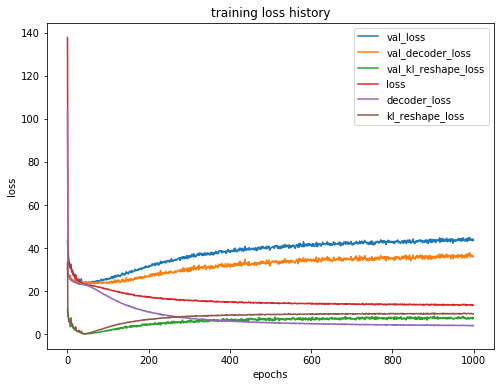

In [59]:
plt.figure(figsize = (8, 6))
for loss in history.history.keys():
    plt.plot(history.history[loss], label=loss)
plt.legend()
plt.title("training loss history")
plt.xlabel("epochs")
plt.ylabel("loss")
plt.savefig("./logs/base_vae_{0}_epochs_training_history.png".format(epochs))

In [64]:
vae_1 = build_vae(latent_dim=20,
                  n_tokens=21, 
                  seq_length=X_train.shape[1],
                  enc1_units=50)
vae_1.encoder_.load_weights("models/vae_0_encoder_weights_{0}.h5".format(epochs))
vae_1.decoder_.load_weights("models/vae_0_decoder_weights_{0}.h5".format(epochs))
vae_1.vae_.load_weights("models/vae_0_vae_weights_{0}.h5".format(epochs))

output_mean_0, output_var_0 = vae_0.encoder_.predict([X_train])
output_mean_1, output_var_1 = vae_1.encoder_.predict([X_train])
np.testing.assert_array_equal(output_mean_0, output_mean_1)
np.testing.assert_array_equal(output_var_0, output_var_1)
z = np.random.sample((1000, 20))
recon_0 = vae_0.decoder_.predict(z)
recon_1 = vae_1.decoder_.predict(z)
np.testing.assert_array_equal(recon_0, recon_1)

In [65]:
vocabulary = get_all_amino_acids()
num_characters = len(vocabulary)
index_to_character = dict(zip(range(num_characters), vocabulary))
wild_type = get_wild_type_amino_acid_sequence()

In [66]:
num_samples = 1000
z = np.random.sample((num_samples, 20))
outputs = vae_1.decoder_.predict(z)
mismatches, all_strings = [], []
for i in range(outputs.shape[0]):
    string = []
    for j in range(outputs.shape[1]):
        k = np.random.choice(list(range(num_characters)), p = outputs[i, j])
        string.append(index_to_character[k])
    all_strings.append("".join(string))
    mismatches.append(count_substring_mismatch(wild_type, all_strings[-1]))
    if i % 100 == 0:
        print("finished {0}/{1} samples".format(i, num_samples))
        

finished 0/1000 samples
finished 100/1000 samples
finished 200/1000 samples
finished 300/1000 samples
finished 400/1000 samples
finished 500/1000 samples
finished 600/1000 samples
finished 700/1000 samples
finished 800/1000 samples
finished 900/1000 samples


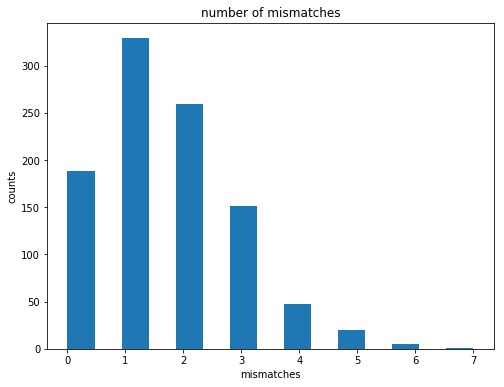

In [67]:
plt.figure(figsize = (8, 6))
plt.title("number of mismatches")
plt.hist(np.array(mismatches), bins=15)
plt.xlabel("mismatches")
plt.ylabel("counts")
plt.savefig("./logs/base_vae_mismatch_from_wild_type_epoch_{0}".format(epochs))

Text(0,0.5,'counts')

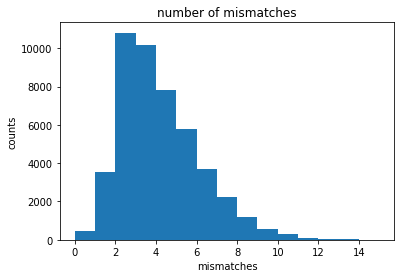

In [68]:
data_mismatches = []
for amino_acid_seq in load_gfp_data("./data/gfp_amino_acid_shuffle_")[0]:
    data_mismatches.append(count_substring_mismatch(amino_acid_seq, wild_type))
plt.title("number of mismatches")
plt.hist(data_mismatches, bins = 15)
plt.xlabel("mismatches")
plt.ylabel("counts")

In [17]:
def run_experimental_weighted_ml(it, repeats=3):
    
    assert it in [0, 1, 2]
    
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    num_models = [1, 5, 20][it]
    RANDOM_STATE = it + 1
    
    X_train, y_train, gt_train  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)
    
    vae_suffix = '_%s_%i' % (train_size_str, RANDOM_STATE)
    oracle_suffix = '_%s_%i_%i' % (train_size_str, num_models, RANDOM_STATE)
    
    vae_0 = build_vae(latent_dim=20,
                  n_tokens=20, 
                  seq_length=X_train.shape[1],
                  enc1_units=50)

    vae_0.encoder_.load_weights("models/vae_0_encoder_weights%s.h5" % vae_suffix)
    vae_0.decoder_.load_weights("models/vae_0_decoder_weights%s.h5"% vae_suffix)
    vae_0.vae_.load_weights("models/vae_0_vae_weights%s.h5"% vae_suffix)
    
    ground_truth = SequenceGP(load=True, load_prefix="data/gfp_gp")
    
    loss = neg_log_likelihood
    get_custom_objects().update({"neg_log_likelihood": loss})
    oracles = [load_model("models/oracle_%i%s.h5" % (i, oracle_suffix)) for i in range(num_models)]
    
    test_kwargs = [
#                    {'weights_type':'cbas', 'quantile': 1},
#                    {'weights_type':'rwr', 'alpha': 20},
#                    {'weights_type':'dbas', 'quantile': 0.95},
#                    {'weights_type':'cem-pi', 'quantile': 0.8},
        {'weights_type': 'fbvae', 'quantile': 0.8}
    ]
    
    base_kwargs = {
        'homoscedastic': False,
        'homo_y_var': 0.01,
        'train_gt_evals':gt_train,
        'samples':100,
        'cutoff':1e-6,
        'it_epochs':10,
        'verbose':True,
        'LD': 20,
        'enc1_units':50,
        'iters':1000
    }
    
    if num_models==1:
        base_kwargs['homoscedastic'] = True
        base_kwargs['homo_y_var'] = np.mean((get_balaji_predictions(oracles, X_train)[0] - y_train)**2)
    
    for k in range(repeats):
        for j in range(len(test_kwargs)):
            test_name = test_kwargs[j]['weights_type']
            suffix = "_%s_%i_%i" % (train_size_str, RANDOM_STATE, k)
            if test_name == 'fbvae':
#                 suffix = suffix + "_%.2f" % test_kwargs[j]['quantile']
                if base_kwargs['iters'] == 1000:
                    suffix += '_long'
            
                print(suffix)
                kwargs = {}
                kwargs.update(test_kwargs[j])
                kwargs.update(base_kwargs)
                [kwargs.pop(k) for k in ['homoscedastic', 'homo_y_var', 'cutoff', 'it_epochs']]
                test_traj, test_oracle_samples, test_gt_samples, test_max = fb_opt(np.copy(X_train), oracles, ground_truth, vae_0, **kwargs)
            else:
                kwargs = {}
                kwargs.update(test_kwargs[j])
                kwargs.update(base_kwargs)
                test_traj, test_oracle_samples, test_gt_samples, test_max = weighted_ml_opt(np.copy(X_train), oracles, ground_truth, vae_0, **kwargs)
                
            np.save('results/%s_traj%s.npy' %(test_name, suffix), test_traj)
            np.save('results/%s_oracle_samples%s.npy' % (test_name, suffix), test_oracle_samples)
            np.save('results/%s_gt_samples%s.npy'%(test_name, suffix), test_gt_samples )

            with open('results/%s_max%s.json'% (test_name, suffix), 'w') as outfile:
                json.dump(test_max, outfile)
        

In [ ]:
def test_cbas_q(qs = [0.5, 0.75, 0.95, 1]):
    it = 0
    
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    num_models = [1, 5, 20][it]
    RANDOM_STATE = it + 1
    
    X_train, y_train, gt_train  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE)
    
    vae_suffix = '_%s_%i' % (train_size_str, RANDOM_STATE)
    oracle_suffix = '_%s_%i_%i' % (train_size_str, num_models, RANDOM_STATE)
    
    vae_0 = build_vae(latent_dim=20,
                  n_tokens=20, 
                  seq_length=X_train.shape[1],
                  enc1_units=50)

    vae_0.encoder_.load_weights("models/vae_0_encoder_weights%s.h5" % vae_suffix)
    vae_0.decoder_.load_weights("models/vae_0_decoder_weights%s.h5"% vae_suffix)
    vae_0.vae_.load_weights("models/vae_0_vae_weights%s.h5"% vae_suffix)
    
    ground_truth = SequenceGP(load=True, load_prefix="data/gfp_gp")
    
    loss = neg_log_likelihood
    get_custom_objects().update({"neg_log_likelihood": loss})
    oracles = [load_model("models/oracle_%i%s.h5" % (i, oracle_suffix)) for i in range(num_models)]
    
    test_kwargs = [ {'weights_type':'cbas', 'quantile': q} for q in qs]
    
    base_kwargs = {
        'homoscedastic': False,
        'homo_y_var': 0.01,
        'train_gt_evals':gt_train,
        'samples':100,
        'cutoff':1e-6,
        'it_epochs':10,
        'verbose':True,
        'LD': 20,
        'enc1_units':50,
        'iters':100
    }
    
    if num_models==1:
        base_kwargs['homoscedastic'] = True
        base_kwargs['homo_y_var'] = np.mean((get_balaji_predictions(oracles, X_train)[0] - y_train)**2)
    
    for j in range(len(test_kwargs)):
        test_name = test_kwargs[j]['weights_type']
        qj = test_kwargs[j]['quantile']
        suffix = "_qtest_%s_%i_%.2f" % (train_size_str, RANDOM_STATE, qj)
        print(suffix)
        kwargs = {}
        kwargs.update(test_kwargs[j])
        kwargs.update(base_kwargs)
        test_traj, test_oracle_samples, test_gt_samples, test_max = weighted_ml_opt(np.copy(X_train), oracles, ground_truth, vae_0, **kwargs)
        
        np.save('results/%s_traj%s.npy' %(test_name, suffix), test_traj)
        np.save('results/%s_oracle_samples%s.npy' % (test_name, suffix), test_oracle_samples)
        np.save('results/%s_gt_samples%s.npy'%(test_name, suffix), test_gt_samples )

        with open('results/%s_max%s.json'% (test_name, suffix), 'w') as outfile:
            json.dump(test_max, outfile)

In [25]:
%load_ext autoreload
%autoreload 2
from util import count_substring_mismatch

ImportError: cannot import name 'count_substring_mismatch'

In [ ]:
# train_experimental_vaes()
# train_experimental_oracles()

# for i in range(1):
#     run_experimental_weighted_ml(i, repeats=1)

test_cbas_q(qs=[0.5, 0.75, 0.95, 1])

In [ ]:
def test_density():
    TRAIN_SIZE = 5000
    train_size_str = "%ik" % (TRAIN_SIZE/1000)
    RANDOM_STATE = it + 1

    X_train, y_train, gt_train, X_test, y_test, gt_test  = get_experimental_X_y(random_state=RANDOM_STATE, train_size=TRAIN_SIZE, return_test=True)

    vae_suffix = '_%s_%i' % (train_size_str, RANDOM_STATE)

    vae_0 = build_vae(latent_dim=20,
              n_tokens=20, 
              seq_length=X_train.shape[1],
              enc1_units=50)

    vae_0.encoder_.load_weights("models/vae_0_encoder_weights%s.h5" % vae_suffix)
    vae_0.decoder_.load_weights("models/vae_0_decoder_weights%s.h5"% vae_suffix)
    vae_0.vae_.load_weights("models/vae_0_vae_weights%s.h5"% vae_suffix)
    
    X_shuffle = np.zeros_like(X_train)
    for i in range